In [425]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [426]:
np.random.seed(28)  # for reproducibility

In [427]:
df = pd.read_csv('data.csv', index_col='datetime', parse_dates=True)

In [428]:
df

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.39,81,0.00,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.63,80,0.00,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.63,80,0.00,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.39,75,0.00,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.39,75,0.00,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,4,0,1,1,15.58,19.70,50,26.00,7,329,336
2012-12-19 20:00:00,4,0,1,1,14.76,17.43,57,15.00,10,231,241
2012-12-19 21:00:00,4,0,1,1,13.94,15.91,61,15.00,4,164,168


In [429]:
df.shape

(10886, 11)

## <font color='Green'>***BUT: On cherche à prédire le nombre de vélos loués par heure dans la ville (variable `count`)***.</font>

# [ **I ) Analyse exploratoire**](#content1)

# [ **II ) Modélisation**](#content2) 

# [ **III ) Explication des modèles & sens métier aux prédictions**](#content3)

<a id="content1"></a>
# <font color='black'>I) Analyse exploratoire</font>
### - Par quelles étapes passes-tu afin de prendre en main la donnée avant de passer à la modélisation ?
### - Quels sont les facteurs qui semblent influencer la demande en vélos ? Illustrer à l'aide de graphiques

$\,$


### Checker les valeurs manquantes

In [430]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [431]:
df_null = (df.isnull().sum()) / len(df) * 100
#df_na = df.drop(df[df==0].index).sort_values(by='count', ascending=False)
df_null

season       0.00
holiday      0.00
workingday   0.00
weather      0.00
temp         0.00
atemp        0.00
humidity     0.00
windspeed    0.00
casual       0.00
registered   0.00
count        0.00
dtype: float64

Il n'y a pas de valeurs manquantes dans chacunes des colonnes.

In [432]:
df_na = (df.isna().sum()) / len(df) * 100
df_na

season       0.00
holiday      0.00
workingday   0.00
weather      0.00
temp         0.00
atemp        0.00
humidity     0.00
windspeed    0.00
casual       0.00
registered   0.00
count        0.00
dtype: float64

Ni de `NaN` valeurs.

### Types des valeurs: catégoriques & numériques

On crée des colonnes temporelles dont nous aurons besoin tels que l'heure, le jour de la semaine, le mois etc. Ces dernières permettront de mieux prédire le nombre total de locations (nous le verrons dans la partie 'modélisation'.

In [433]:
# Create hours, days, weeks, months, year 
df['week'] = df.index.week
df['day_month'] = df.index.day
df['year'] = df.index.year
df['months'] = df.index.month
df['day'] = df.index.dayofweek
df['hour'] = df.index.hour
df['weekend'] = (df['day'] > 4).astype(int)

In [399]:
df.dtypes

season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
week            int64
day_month       int64
year            int64
months          int64
day             int64
hour            int64
weekend         int64
dtype: object

In [316]:
# Check for categorical values
print('-'*35)
print('First 5 uniques values from columns')
print('-'*35, '\n')
for col in df.columns:
    print(f'- {col} : {df[col].unique()[:5]}')

-----------------------------------
First 5 uniques values from columns
----------------------------------- 

- season : [1 2 3 4]
- holiday : [0 1]
- workingday : [0 1]
- weather : [1 2 3 4]
- temp : [ 9.84  9.02  8.2  13.12 15.58]
- atemp : [14.395 13.635 12.88  17.425 19.695]
- humidity : [81 80 75 86 76]
- windspeed : [ 0.      6.0032 16.9979 19.0012 19.9995]
- casual : [3 8 5 0 2]
- registered : [13 32 27 10  1]
- count : [16 40 32 13  1]
- week : [52  1  2  3  5]
- day_month : [1 2 3 4 5]
- year : [2011 2012]
- months : [1 2 3 4 5]
- day : [5 6 0 1 2]
- hour : [0 1 2 3 4]
- weekend : [1 0]


Avant la modélisation 'partie Feature engineering on transformera certaines colonnes en catégoriques.

In [283]:
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,week_number,day_month,year,months,day,hour,weekend,week
count,10886.00,10886.00,10886.00,10886.00,10886.00,10886.00,10886.00,10886.00,10886.00,10886.00,10886.00,10886.00,10886.00,10886.00,10886.00,10886.00,10886.00,10886.00,10886.00
mean,2.51,0.03,0.68,1.42,20.23,23.66,61.89,12.80,36.02,155.55,191.57,25.92,9.99,2011.50,6.52,3.01,11.54,0.29,25.92
std,1.12,0.17,0.47,0.63,7.79,8.47,19.25,8.16,49.96,151.04,181.14,15.02,5.48,0.50,3.44,2.00,6.92,0.45,15.02
min,1.00,0.00,0.00,1.00,0.82,0.76,0.00,0.00,0.00,0.00,1.00,1.00,1.00,2011.00,1.00,0.00,0.00,0.00,1.00
25%,2.00,0.00,0.00,1.00,13.94,16.66,47.00,7.00,4.00,36.00,42.00,14.00,5.00,2011.00,4.00,1.00,6.00,0.00,14.00
50%,3.00,0.00,1.00,1.00,20.50,24.24,62.00,13.00,17.00,118.00,145.00,26.00,10.00,2012.00,7.00,3.00,12.00,0.00,26.00
75%,4.00,0.00,1.00,2.00,26.24,31.06,77.00,17.00,49.00,222.00,284.00,40.00,15.00,2012.00,10.00,5.00,18.00,1.00,40.00
max,4.00,1.00,1.00,4.00,41.00,45.45,100.00,57.00,367.00,886.00,977.00,52.00,19.00,2012.00,12.00,6.00,23.00,1.00,52.00


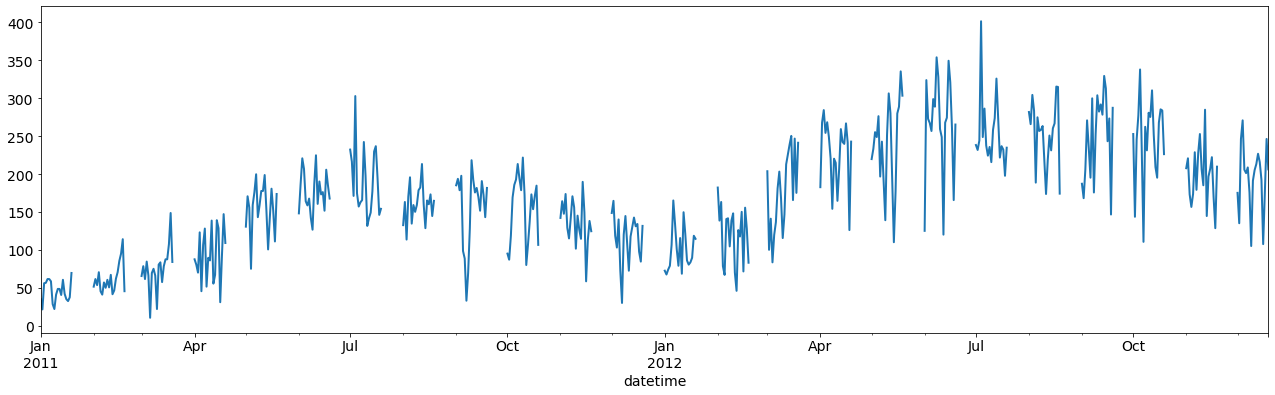

In [169]:
df_day = df.groupby(pd.Grouper(freq='d'))

with plt.rc_context(rc={'font.size':14}): 
    fig, ax = plt.subplots(figsize=(22,6))
    df_day['count'].median().plot(ax=ax, lw=2)

In [53]:
# Check the data consistency
df[:500:24].index

DatetimeIndex(['2011-01-01 00:00:00', '2011-01-02 00:00:00',
               '2011-01-03 01:00:00', '2011-01-04 04:00:00',
               '2011-01-05 05:00:00', '2011-01-06 06:00:00',
               '2011-01-07 07:00:00', '2011-01-08 07:00:00',
               '2011-01-09 07:00:00', '2011-01-10 07:00:00',
               '2011-01-11 09:00:00', '2011-01-12 11:00:00',
               '2011-01-13 11:00:00', '2011-01-14 12:00:00',
               '2011-01-15 12:00:00', '2011-01-16 12:00:00',
               '2011-01-17 12:00:00', '2011-01-19 00:00:00',
               '2011-02-01 01:00:00', '2011-02-02 02:00:00',
               '2011-02-03 02:00:00'],
              dtype='datetime64[ns]', name='datetime', freq=None)

**Remarque: Il n'y a des données que jusqu'au 19 du mois.**

### **Étude avec les données *catégoriques***

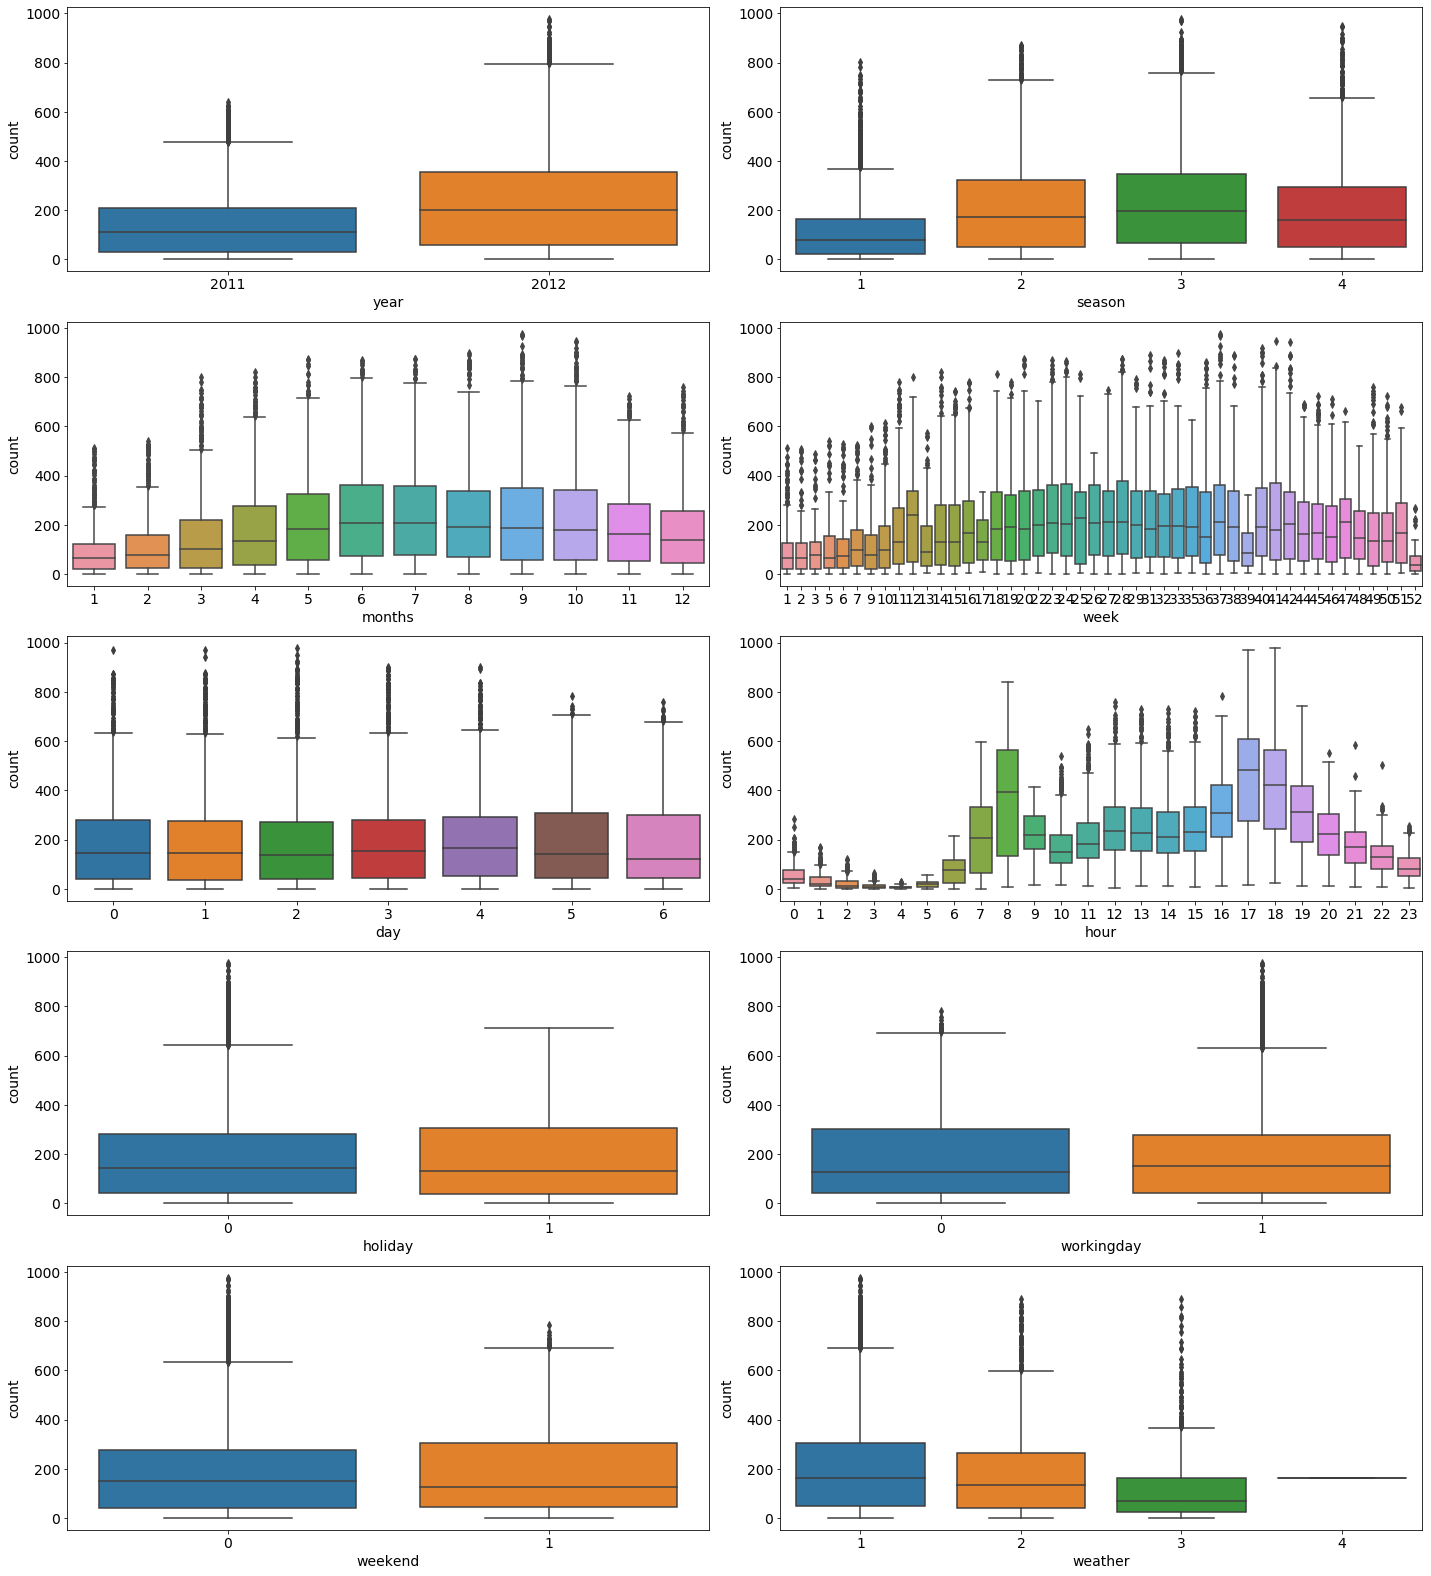

In [60]:
cols = 'year season months week day hour holiday workingday weekend  weather'.split()

with plt.rc_context(rc={'font.size':14}): 
    fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6), (ax7,ax8), (ax9,ax10)) = plt.subplots(5,2, figsize=(20,22), tight_layout=True)       
    for col, ax in zip(cols, [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10]):       
        sns.boxplot(x=df[col], y=df['count'], ax=ax)

À partir de ces distributions on peut déjà noter quelques résultats sur le nombre **total** de locations (qui seront à confirmer par la suite lors d'études statistiques plus fines):
- augmentation des locations entre 2011 et 2012
- locations plus importantes l'été et l'automne (faible au printemps)
- locations importantes aux horaires de travail (6-9h & 16-19h)

### **Corrélations**
Avant de faire du *features engineering* ou autre, une façon d'avoir une idée des variables les plus corrélés avec la *target* (`count`) est de calculer la matrice de corrélation.

In [213]:
# Finding the correlations
corr = df.corr()   

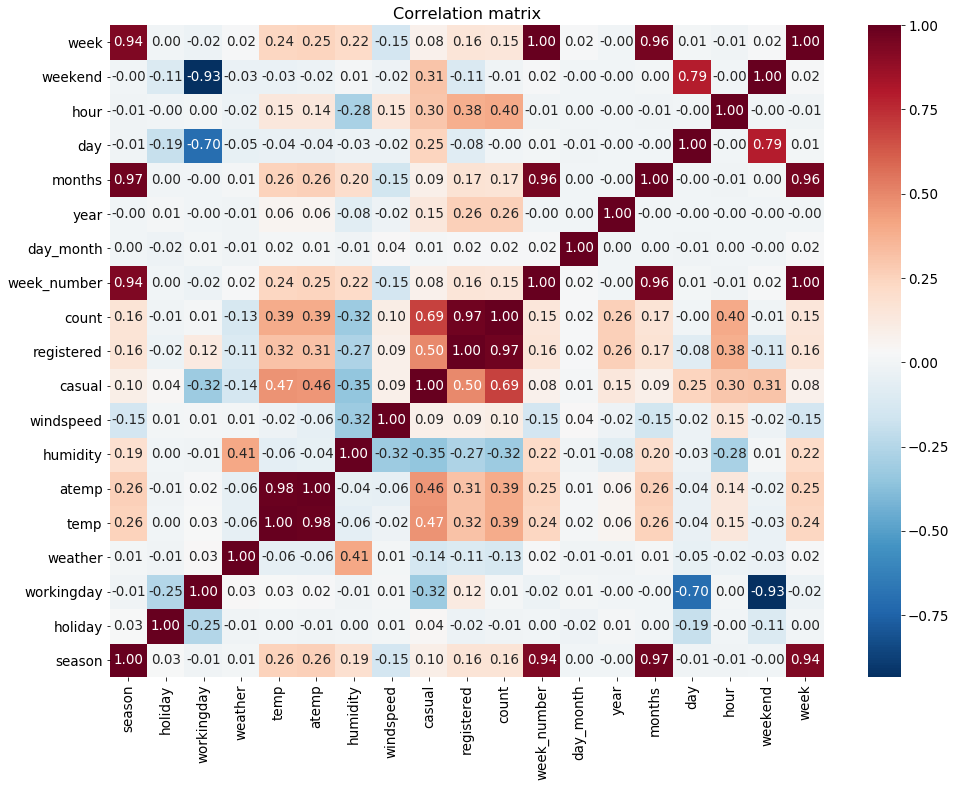

In [212]:
# Most correlated variables
threshold = 0
top_corr_features = corr.index[np.abs(corr['count']) > threshold]
#print(top_corr_features)

# Plot correlation
with plt.rc_context(rc={'font.size':13.5}): 
    fig, ax = plt.subplots(figsize=(16, 12))
    sns.heatmap(df[top_corr_features].corr(), annot=True, 
                fmt='.2f', cmap='RdBu_r', ax=ax)
    ax.set(ylim=[0, 19], title='Correlation matrix')

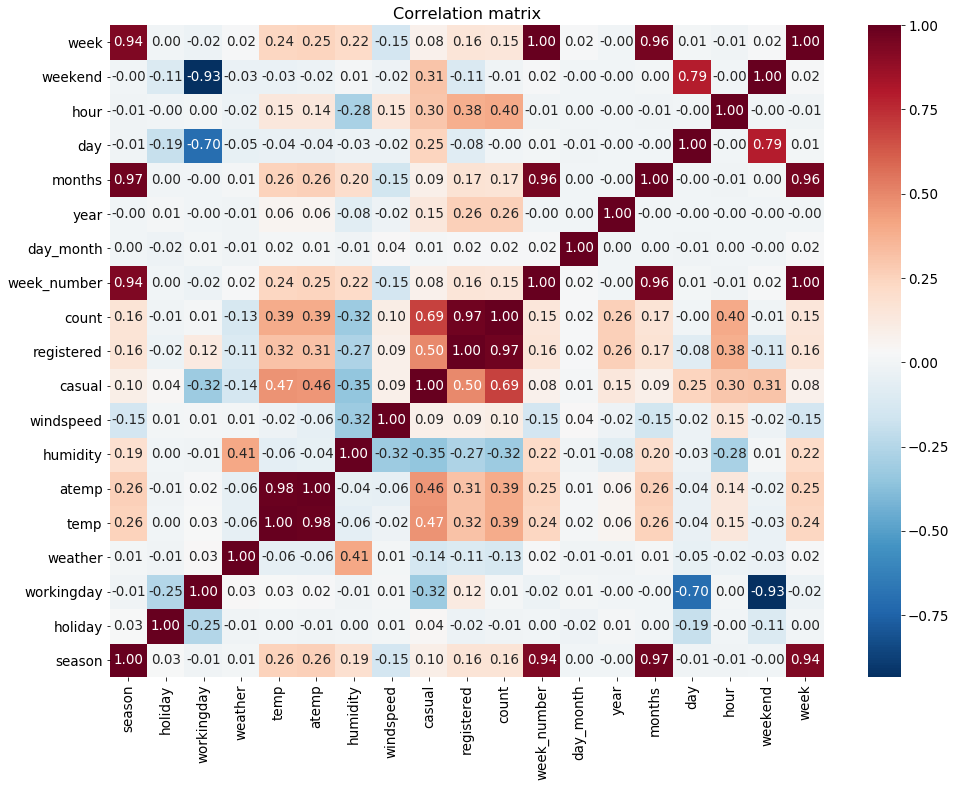

In [212]:
# Most correlated variables
threshold = 0
top_corr_features = corr.index[np.abs(corr['count']) > threshold]
#print(top_corr_features)

# Plot correlation
with plt.rc_context(rc={'font.size':13.5}): 
    fig, ax = plt.subplots(figsize=(16, 12))
    sns.heatmap(df[top_corr_features].corr(), annot=True, 
                fmt='.2f', cmap='RdBu_r', ax=ax)
    ax.set(ylim=[0, 19], title='Correlation matrix')

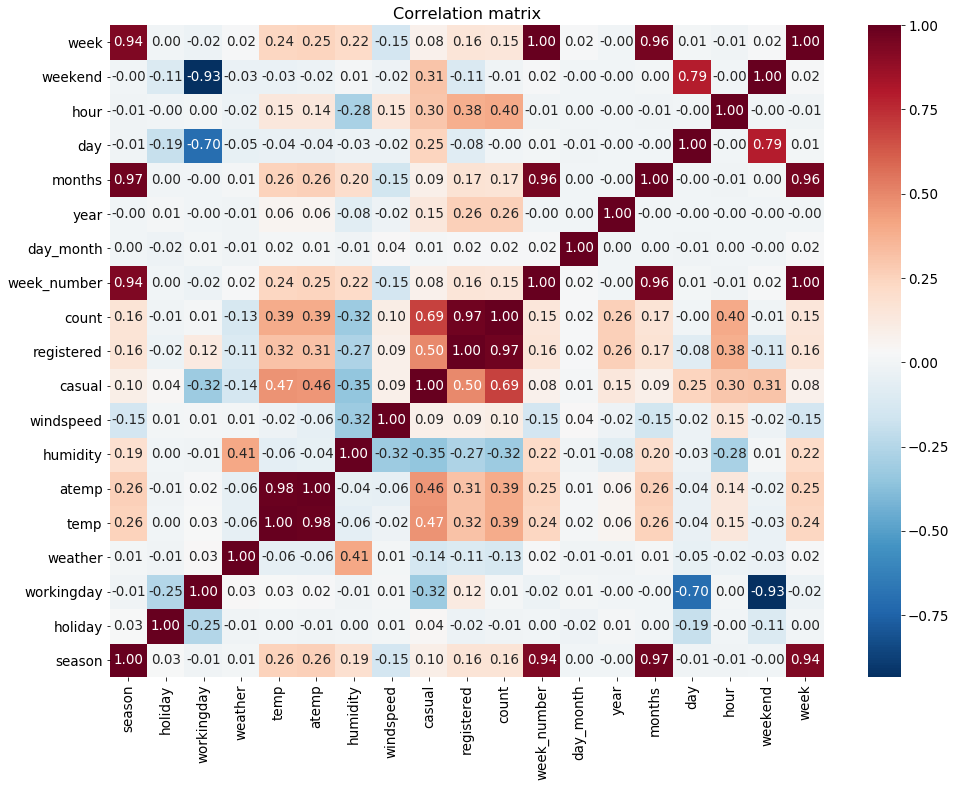

In [212]:
# Most correlated variables
threshold = 0
top_corr_features = corr.index[np.abs(corr['count']) > threshold]
#print(top_corr_features)

# Plot correlation
with plt.rc_context(rc={'font.size':13.5}): 
    fig, ax = plt.subplots(figsize=(16, 12))
    sns.heatmap(df[top_corr_features].corr(), annot=True, 
                fmt='.2f', cmap='RdBu_r', ax=ax)
    ax.set(ylim=[0, 19], title='Correlation matrix')

In [285]:
print(corr['count'].sort_values(ascending=False))

count          1.00
registered     0.97
casual         0.69
hour           0.40
temp           0.39
atemp          0.39
year           0.26
months         0.17
season         0.16
week_number    0.15
week           0.15
windspeed      0.10
day_month      0.02
workingday     0.01
day           -0.00
holiday       -0.01
weekend       -0.01
weather       -0.13
humidity      -0.32
Name: count, dtype: float64


Il y a plein d'informations utiles:
- **week number** est très corrélé avec la variable **mois** et très peu avec le nombre total de locations on pourra donc l'enlever lors de la modélisation
- **weekend** est très corrélé avec **workingday**, il suffira donc de considérer uniquement l'une de ces 2 variables

Globalement, cela permet d'avoir un indice sur les composantes qui impactent le plus le nombre de locations / heures:
- **registered**, **casual**, **hour**, **temp**, **humidity**, **year** sont les principales

Toutefois, du fait que registered + casual = count, afin de prédire **count** nous n'utiliserons pas les colonnes registered et count

### **Variables numériques**

### **Count - Température**

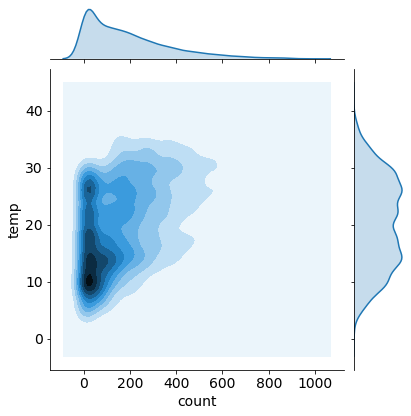

In [422]:
# 2D KDE plot - Correlations
with plt.rc_context(rc={'font.size':14}): 
    sns.jointplot(x=df['count'], y=df['temp'], kind='kde')       # temperature  

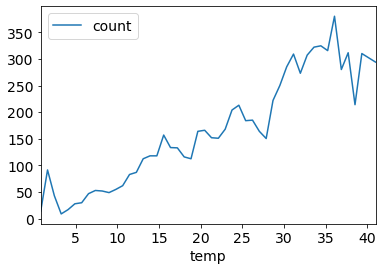

In [170]:
with plt.rc_context(rc={'font.size':14}): 
    df.pivot_table(index='temp', values='count', aggfunc='median').plot()

### **Température - Ressentie**

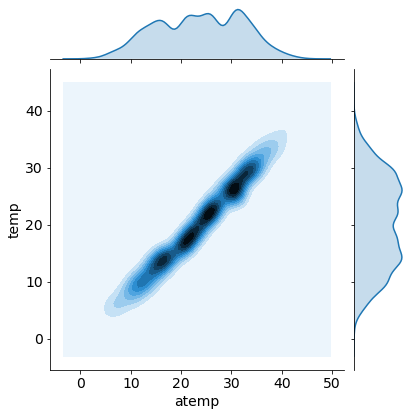

In [144]:
# 2D KDE plot - Correlations
with plt.rc_context(rc={'font.size':14}): 
    sns.jointplot(x=df['atemp'], y=df['temp'], kind='kde')       # temperature  

In [147]:
print(f'Pearson coefficient: {stats.pearsonr(df.temp, df.atemp)[0]:.2f}')

Pearson coefficient: 0.98


**Nous n'utiliserons donc pas la variable *atemp* lors des prédictions (info redondante qui peut biaiser les modèles car cela engendrerait de la *multicolinearity*)**.

### **Count - Humidité**

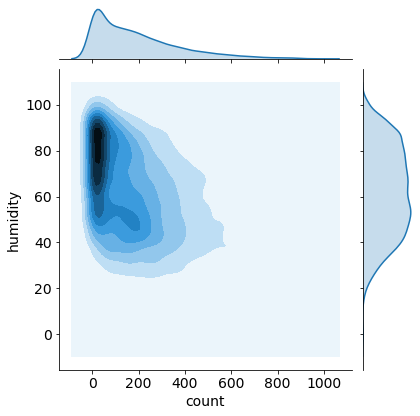

In [153]:
with plt.rc_context(rc={'font.size':14}): 
    sns.jointplot(x=df['count'], y=df['humidity'], kind='kde')       # humidity  

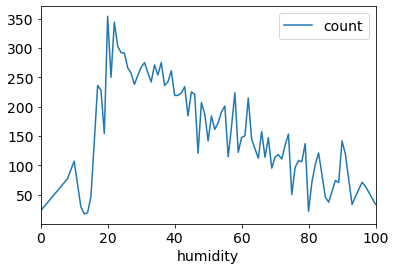

In [171]:
with plt.rc_context(rc={'font.size':14}): 
    df.pivot_table(index='humidity', values='count', aggfunc='median').plot()

### **Count - Windspeed**

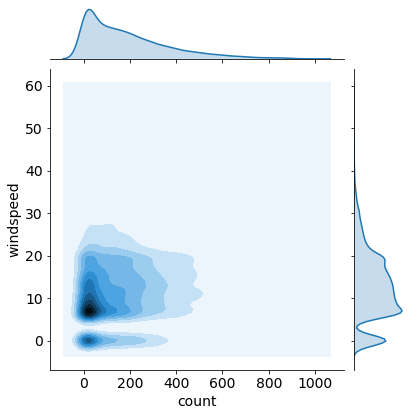

In [148]:
with plt.rc_context(rc={'font.size':14}): 
    sns.jointplot(x=df['count'], y=df['windspeed'], kind='kde')       # windspeed  

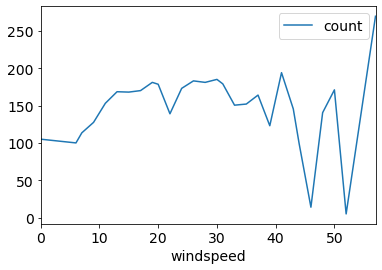

In [172]:
with plt.rc_context(rc={'font.size':14}): 
    df.pivot_table(index='windspeed', values='count', aggfunc='median').plot()

## **Dépendance temporelle** (dans la journée, dans la semaine, dans l'année)

In [63]:
months = 'Jan. Feb. March April May June July Aug. Sept. Oct. Nov. Dec.'.split()
days = 'lundi mardi mercredi jeudi vendredi samedi dimanche'.split()

### <font color='Black'>**Évolution annuelle**</font>

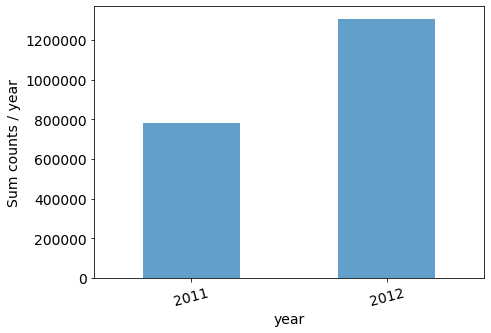

In [166]:
with plt.rc_context(rc={'font.size':14}): 
    fig, ax = plt.subplots(figsize=(7,5))
    df.groupby('year')['count'].sum().plot(kind='bar', alpha=0.7, ax=ax)
    ax.set(ylabel='Sum counts / year')
    ax.tick_params(axis='x', rotation=15)

In [165]:
sum_year = df.groupby('year')['count'].sum().values
augm = sum_year[1] / sum_year[0] 
print(f'Augmentation du nombre total de locations de {(augm - 1)*100:.1f}% entre 2011 et 2012 !')

Augmentation du nombre total de locations de 66.7% entre 2011 et 2012 !


### <font color='Black'>**Évolution de 2011/01 à 2012/12**</font>

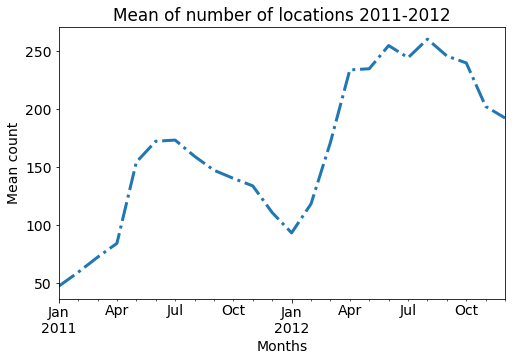

In [423]:
df_month = df.groupby(pd.Grouper(freq='M'))
with plt.rc_context(rc={'font.size':14}): 
    fig, ax = plt.subplots(figsize=(8,5))     
    df_month['count'].median().plot(ax=ax, ls='-.', lw=3)
    ax.set(title='Mean of number of locations 2011-2012', 
           xlabel='Months', ylabel='Mean count')

On peut ainsi remarquer une tendance ! Examinons cela de plus près.

In [174]:
from statsmodels.tsa.seasonal import seasonal_decompose

data = df.groupby(pd.Grouper(freq='M'))
data = data['count'].median()

# Multiplicative Decomposition 
result_mul = seasonal_decompose(data, model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(data, model='additive', extrapolate_trend='freq')

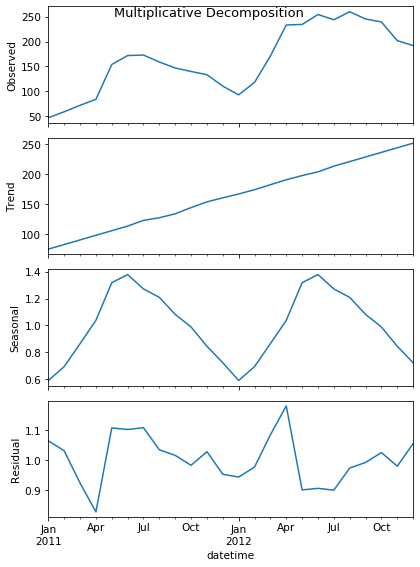

In [175]:
plt.rcParams['figure.figsize'] = (6,8)
with plt.rc_context(rc={'font.size':10.5}): 
    result_mul.plot().suptitle('Multiplicative Decomposition', fontsize=13)
#result_add.plot().suptitle('Additive Decomposition', fontsize=15)
plt.rcParams['figure.figsize'] = (6,4)  # set default

Cela fournit déjà un première idée de la tendance générale du nombre totale de locations. Bien sûr par la suite on va utiliser des modèles plus complexes afin de prédire au mieux ce nombre. Il serait intéressant à la fin de comparer nos modèles de Machine Learning avec ce modèle-ci.

### <font color='Black'>**Évolution mensuelle**</font>

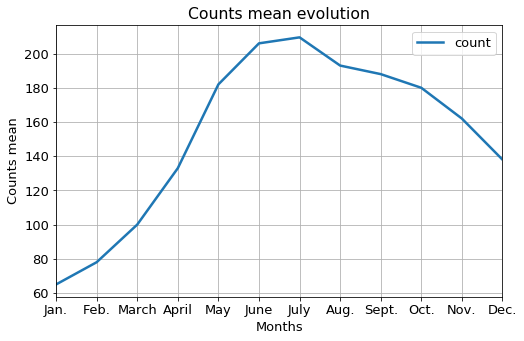

In [177]:
with plt.rc_context(rc={'font.size':13}): 
    fig, ax = plt.subplots(figsize=(8,5))
    df.pivot_table(values='count', index='months', aggfunc='median').plot(ax=ax, lw=2.5)
    ax.set(xlabel='Months', ylabel='Counts mean', title='Counts mean evolution', 
           xticklabels=months, xticks=np.arange(1,13))
    ax.grid()

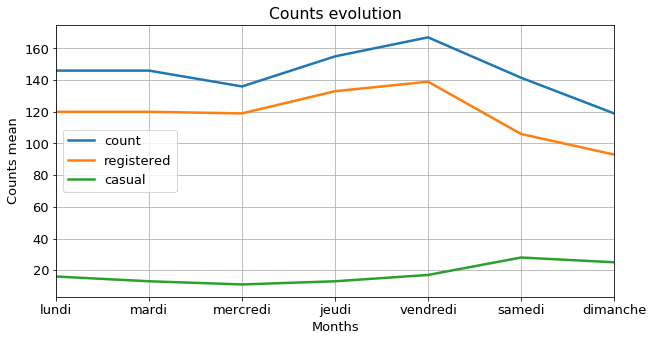

In [294]:
with plt.rc_context(rc={'font.size':13}): 
    fig, ax = plt.subplots(figsize=(10,5))
    df.pivot_table(values='count', index='day', aggfunc='median').plot(ax=ax, lw=2.5)
    df.pivot_table(values='registered', index='day', aggfunc='median').plot(ax=ax, lw=2.5)
    df.pivot_table(values='casual', index='day', aggfunc='median').plot(ax=ax, lw=2.5)
    ax.set(xlabel='Months', ylabel='Counts mean', title='Counts evolution', 
           xticklabels=days, xticks=np.arange(0,7))
    ax.grid()

### <font color='Red'>***Évolution journalière (et hebmodaire)***</font> 
(but de l'étude)

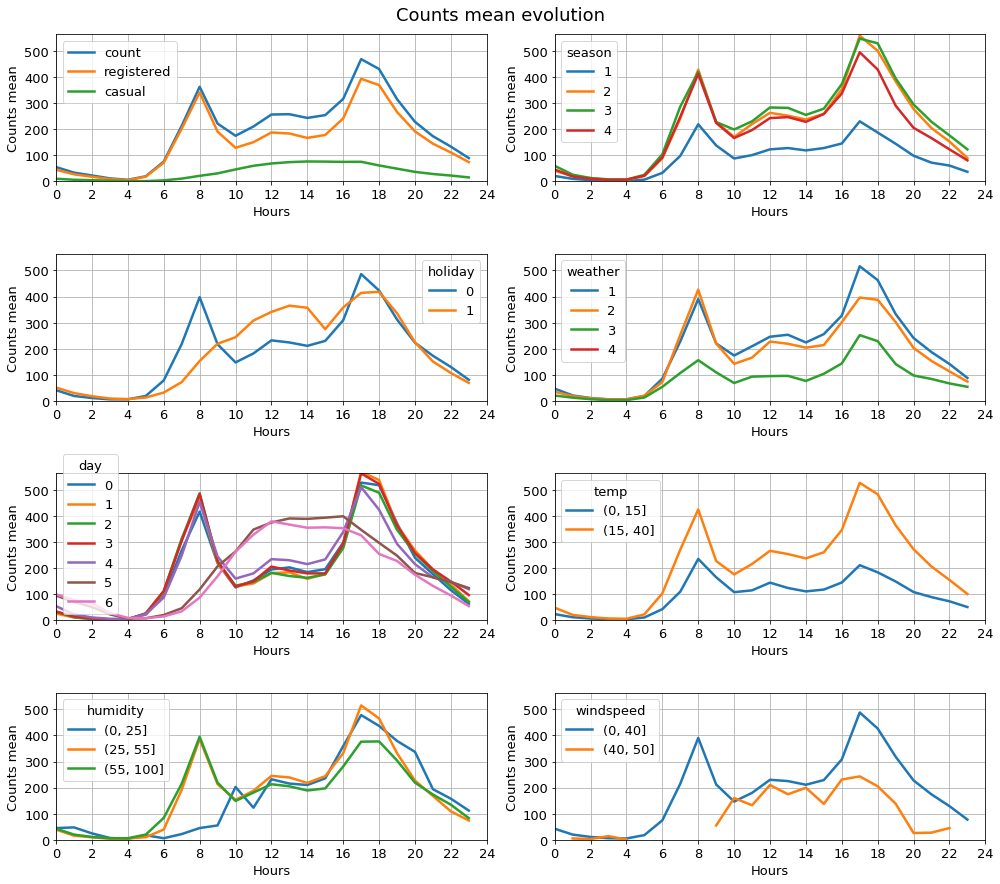

In [296]:
# On groupe par température, humidité et vitesse du vent
temp_cut = pd.cut(df['temp'], [0, 15, 40])
humid_cut = pd.cut(df['humidity'], [0, 25, 55, 100])  # 25-55% idéal
wind_cut = pd.cut(df['windspeed'], [0, 40, 50])

with plt.rc_context(rc={'font.size':13}): 
    fig, ((ax0,ax1), (ax2,ax3), (ax4,ax5), (ax6,ax7)) = plt.subplots(4,2, figsize=(14,12), 
                                                                     tight_layout=True)
    # Location partielles/totales par heure
    df.pivot_table(values='count', index='hour', aggfunc='mean').plot(ax=ax0, lw=2.5)
    df.pivot_table(values='registered', index='hour', aggfunc='mean').plot(ax=ax0, lw=2.5)
    df.pivot_table(values='casual', index='hour', aggfunc='mean').plot(ax=ax0, lw=2.5)    
    
    # Autres catégories
    df.pivot_table(values='count', index='hour', columns='season', aggfunc='median').plot(ax=ax1, lw=2.5)
    df.pivot_table(values='count', index='hour', columns='holiday', aggfunc='median').plot(ax=ax2, lw=2.5)
    df.pivot_table(values='count', index='hour', columns='weather', aggfunc='median').plot(ax=ax3, lw=2.5)
    df.pivot_table(values='count', index='hour', columns='day', aggfunc='median').plot(ax=ax4, lw=2.5)
    df.pivot_table(values='count', index='hour', columns=temp_cut, aggfunc='median').plot(ax=ax5, lw=2.5)
    df.pivot_table(values='count', index='hour', columns=humid_cut, aggfunc='median').plot(ax=ax6, lw=2.5)
    df.pivot_table(values='count', index='hour', columns=wind_cut, aggfunc='median').plot(ax=ax7, lw=2.5)

    for ax in [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7]:
        ax.set(xticks=np.arange(0,26,2), ylim=[0, plt.ylim()[1]*1.1], 
               xlabel='Hours', ylabel='Counts mean')
        ax.grid()
    fig.suptitle('Counts mean evolution', fontsize=18, y=1.02)

***On peut déjà tirer de nombreux résultats***:
- 2 pics de locations de vélos de 6h à 9h et de 16h à 19h: axés sur les horaires de travail du lundi au vendredi
- week-end: pic entre 10h et 19h: plus étalé sur la journée
- vacances: comportements similaires au week-end
- locations minimales au Printemps
- en cas de pluie: peu de locations voir pas du tout lors de neiges/fortes pluies
- température: dès qu'il fait suffisament bon (>15 °C) les locations sont plus importantes
- humidité: s'il fait très sec (taux < 25%), les locations sont très faibles le matin (très probablement pour ne pas arriver transpirant au travail). En revanche, le soir même s'il fait sec cela ne pose pas de soucis, les locations suivent les tendances des locations en cas de taux d'humidité favorable (et importantes)
- vent: si la vitesse du vent est trop importante (> 40 km/h), il n'y a pas de locations le matin (surement pour ne pas arriver également transpirant au travail). Le soir, les locations sont modérés. 

### Dépendance dans le mois

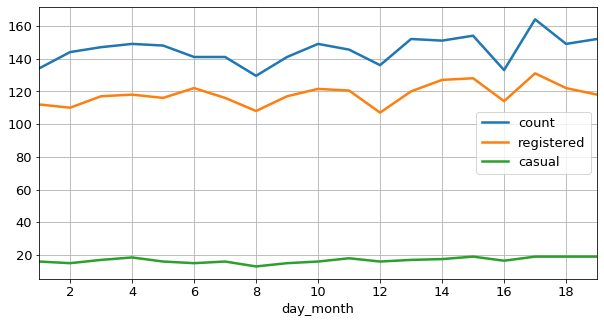

In [434]:
with plt.rc_context(rc={'font.size':13}): 
    fig, ax = plt.subplots(figsize=(10,5))
    df.pivot_table(values='count', index='day_month', aggfunc='median').plot(ax=ax, lw=2.5)
    df.pivot_table(values='registered', index='day_month', aggfunc='median').plot(ax=ax, lw=2.5)
    df.pivot_table(values='casual', index='day_month', aggfunc='median').plot(ax=ax, lw=2.5)    
    ax.grid()

On ne note pas de tendance spécifique au sein d'un même mois.

### ***Tendances abonnées vs. non abonnés***

In [261]:
palette = sns.color_palette('bright', 4)
def plot_count_categ(hue, titles='Total_count Registered Casual'.split(), 
                     col='months', estimator=np.median, fontsize=12,
                     palette=palette):
    with plt.rc_context(rc={'font.size':fontsize}): 
        fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,4))
        N = len(df[hue].unique())
        sns.lineplot(x=col, y='count', data=df, estimator=estimator, hue=hue, palette=palette[:N], ax=ax1)
        sns.lineplot(x=col, y='registered', data=df, estimator=estimator, hue=hue, palette=palette[:N], ax=ax2)
        sns.lineplot(x=col, y='casual', data=df, estimator=estimator, hue=hue, palette=palette[:N], ax=ax3)
        for t, ax in zip(titles, [ax1,ax2,ax3]):
            ax.set(title=t)
            ax.legend(loc='best')

#### **Working-day**

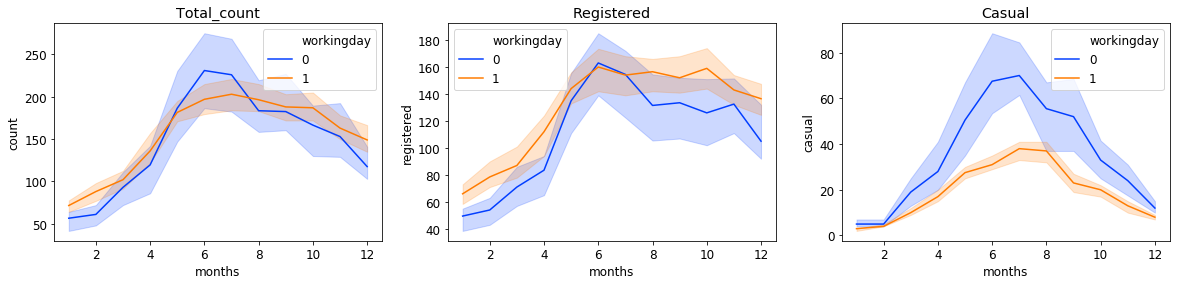

In [262]:
plot_count_categ('workingday')

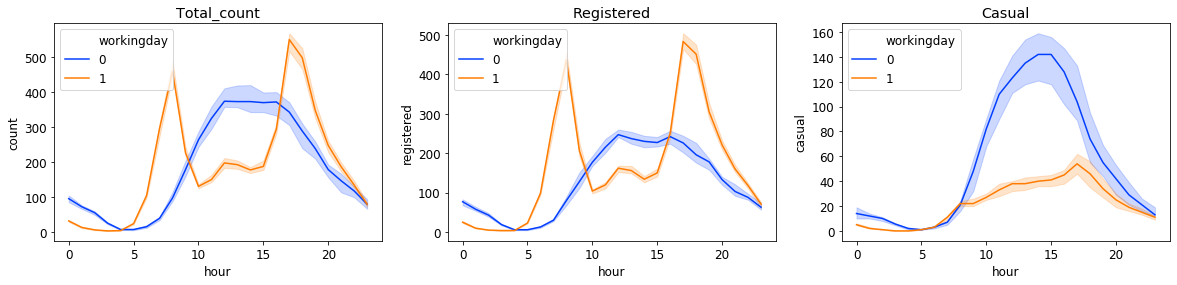

In [263]:
plot_count_categ('workingday', col='hour')

#### **Holiday**

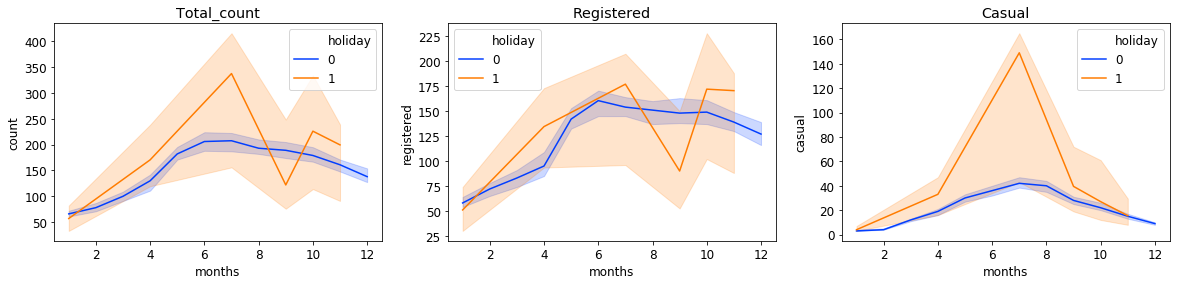

In [266]:
plot_count_categ('holiday')

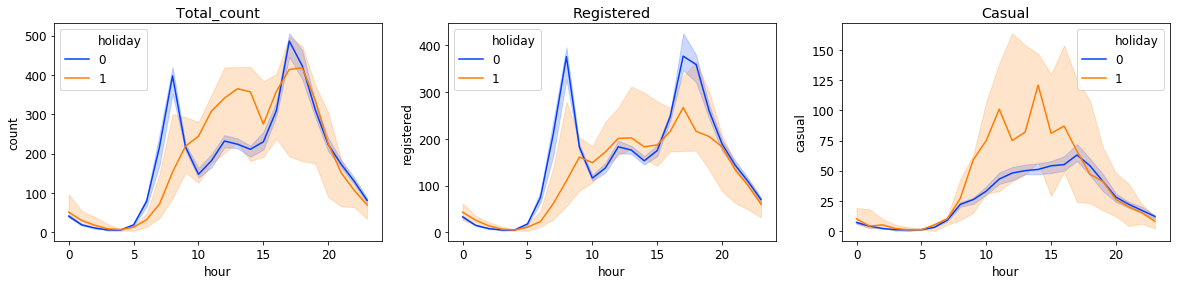

In [267]:
plot_count_categ('holiday', col='hour')

#### **Weather**

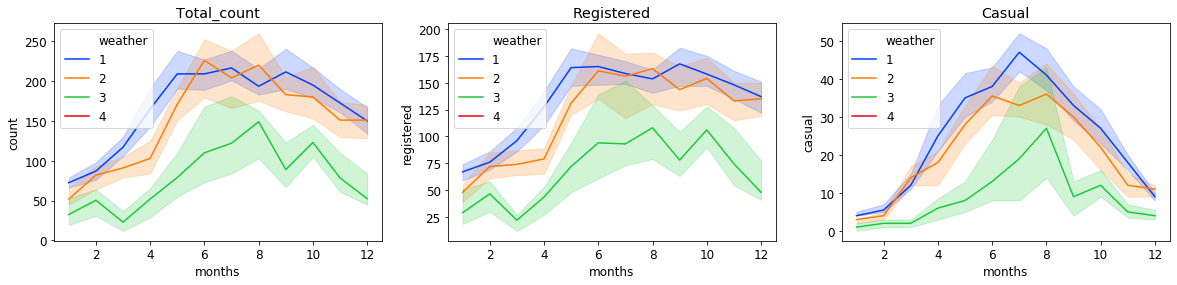

In [264]:
plot_count_categ('weather')

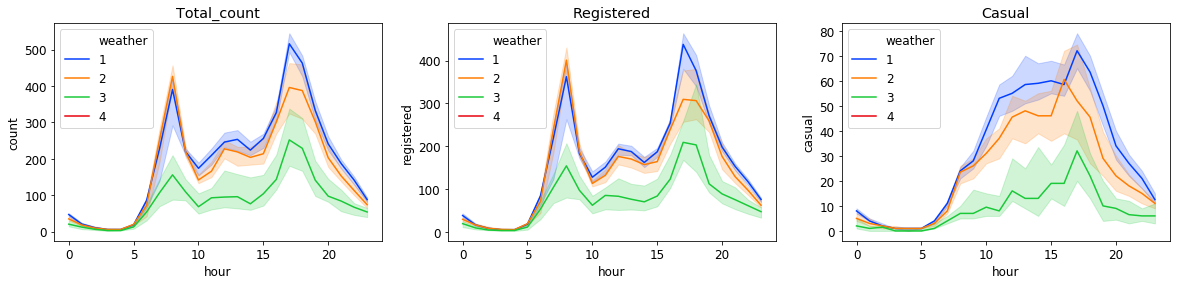

In [265]:
plot_count_categ('weather', col='hour')

- On peut remarquer que les locations ***casual*** ont majoritairement lieu le week-end (~ entre 10 et 20h).
- De plus, les locations ***casual*** sont maximales en cas de vacances entre Avril et Octobre.

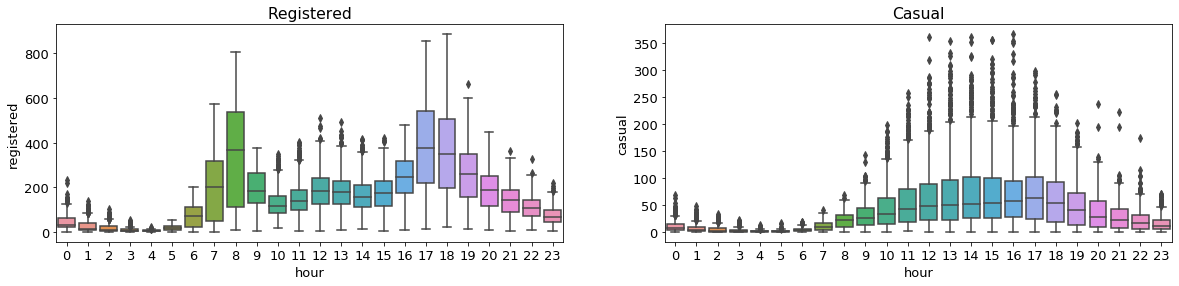

In [269]:
with plt.rc_context(rc={'font.size':13}): 
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,4))
    sns.boxplot(x='hour', y='registered', data=df, ax=ax1)
    sns.boxplot(x='hour', y='casual', data=df, ax=ax2)
    for t, ax in zip('Registered Casual'.split(), [ax1,ax2]):
        ax.set(title=t)

In [297]:
df['casual'].describe()

count   10886.00
mean       36.02
std        49.96
min         0.00
25%         4.00
50%        17.00
75%        49.00
max       367.00
Name: casual, dtype: float64

On peut remarquer des ***outliers*** des usagers non abonnés qui se réfletent au sein de la distribution totale $\rightarrow$ nous allons ainsi effectuer une **log-transformation** pour 'normaliser' la distribution `count`.

### **Total des locations**

In [300]:
df['count'].describe()

count   10886.00
mean      191.57
std       181.14
min         1.00
25%        42.00
50%       145.00
75%       284.00
max       977.00
Name: count, dtype: float64

The count skewness of count is 1.24


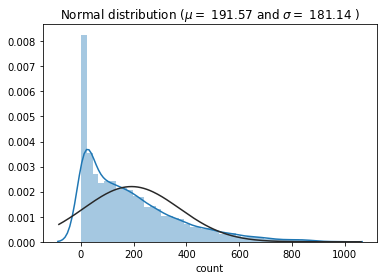

In [405]:
# Check distribution
def skew_distribution(data, col='count'):
    fig, ax1 = plt.subplots()
    sns.distplot(data[col], ax=ax1, fit=stats.norm)
    (mu, sigma) = stats.norm.fit(data[col])
    ax1.set(title='Normal distribution ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma))

    #fig, ax2 = plt.subplots()
    #stats.probplot(data[col], plot=plt)
    print('The {} skewness of count is {:.2f}'.format(col, stats.skew(data[col])))

skew_distribution(df)

<img src='https://saylordotorg.github.io/text_essentials-of-geographic-information-systems/section_10/e8b3fa38d26678631d8c8c2c7822011b.jpg' width='550'>

Pour appliquer des modèles de Machine Learning (ML), il est préférables d'avoir des données distribués normalement: un moyen est donc de tranformer les données grâce au log afin d'avoir une *sknewness* proche de zéro (cela permet également de tenir compte des outliers).

The count_log skewness of count is 0.06


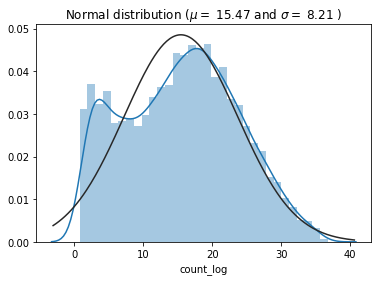

In [440]:
from scipy.special import boxcox1p, inv_boxcox1p

df['count_log'] = boxcox1p(df['count'], 0.4)
skew_distribution(df, col='count_log')

## **Feature engineering**
#### Créer des features qui ont plus de sens (et vérifier a posteriori si ces new features ont de *l'importance* via des modèles comme `Lasso` ou `RandomForrest`)

In [435]:
df.drop(columns='atemp', axis=1, inplace=True)
df.drop(columns='registered', axis=1, inplace=True)
df.drop(columns='casual', axis=1, inplace=True)

In [436]:
# April - October
df['seasonality'] = np.where((df['months'] >= 4) & (df['months'] <= 10), 1 ,0)

# rush, ideal variables
df['ideal'] = np.where((df['temp'] > 15) & (df['windspeed'] < 40) & (df['humidity'] < 70) & (df['humidity'] > 20) , 1, 0)
df['rush'] = np.where(((df['workingday'] == 1) & ((df['hour'] >= 6) & (df['hour'] <= 9)) | ((df['hour'] >= 16) & (df['hour'] <= 19)) )    # week
                      | (((df['workingday'] == 0) | (df['holiday'] == 1)) & (df['hour'] > 10) & (df['hour'] < 19)), 1, 0)    # week-end 
#df['humid_day'] = np.where((df['workingday'] == 1) & (df['humidity'] >= 50), 1, 0)

In [437]:
df.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'humidity',
       'windspeed', 'count', 'week', 'day_month', 'year', 'months', 'day',
       'hour', 'weekend', 'seasonality', 'ideal', 'rush'],
      dtype='object')

In [438]:
cols = 'season holiday workingday weather week day_month year months day hour weekend seasonality ideal rush'.split()

for col in cols:
    df[col] = df[col].astype(str)

In [441]:
num_cols = df.select_dtypes(exclude='object').columns
print('{} Numeric columns \n-----------------\n{}'.format(len(num_cols), num_cols.values))

categ_cols = df.select_dtypes(include='object').columns
print('\n{} Categorical columns \n----------------------\n{}'.format(len(categ_cols), categ_cols.values))

5 Numeric columns 
-----------------
['temp' 'humidity' 'windspeed' 'count' 'count_log']

14 Categorical columns 
----------------------
['season' 'holiday' 'workingday' 'weather' 'week' 'day_month' 'year'
 'months' 'day' 'hour' 'weekend' 'seasonality' 'ideal' 'rush']


In [442]:
print(df.shape, 'before dummy categories')
df = pd.get_dummies(df)
print(df.shape, 'after dummy categories')

(10886, 19) before dummy categories
(10886, 135) after dummy categories


In [444]:
#df.columns.to_series().groupby(df.dtypes).groups

<a id="content2"></a>
# <font color='blue'>II) Modélisation</font>
### - Construis un premier modèle permettant de prédire la variable count et explique ton choix et ta démarche.
### - Evalue la performance de ton modèle et explique le critère de performance choisi.
### - Quelles pistes d’améliorations imagines-tu ? $\rightarrow$ 
- more feature engineering
- implementer abonnées et casual clients and predict count with separates models
- get more year data (2012-2020) and study autocorrelation to build robust model of seasonality
- GridSearch on more hyperparams
- Stacked models to get better predictors

In [492]:
# import librairies 
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

In [470]:
###########
## Metrics 
###########

def compute_rmse(ytrue, ypred):
    return np.sqrt(mean_squared_error(ytrue, ypred))

def compute_rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

### 2.1) ***Diviser les données en train/test***

On ne peut pas utiliser un `train_test_split` de façon classique car ici ce sont des données temporelles. Cela pourrait conduire à des biais si des données `test` étaient comprises entre des données `train`.

Ici, on va découper nos données de Janvier 2011 à Juillet 2011 (**TRAINING**) et de Août à Décembre 2012 (**TEST**).

In [451]:
tsv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tsv.split(df):
    df_train, df_test = df.iloc[train_index, :], df.iloc[test_index, :]
    print("TRAIN:", df_train.shape, "TEST:", df_test.shape)

TRAIN: (1816, 135) TEST: (1814, 135)
TRAIN: (3630, 135) TEST: (1814, 135)
TRAIN: (5444, 135) TEST: (1814, 135)
TRAIN: (7258, 135) TEST: (1814, 135)
TRAIN: (9072, 135) TEST: (1814, 135)


In [455]:
columns = df.columns.drop(['count', 'count_log'])

X_train, y_train = df_train[columns], df_train['count_log']
X_test, y_test = df_test[columns], df_test['count_log']

### 2.2) **Modèle de référence (très basique)**

In [466]:
reg_mean = DummyRegressor(strategy='mean')
reg_mean = reg_mean.fit(X_train, y_train)
dummy_pred = reg_mean.predict(X_test)
print(f'RMSE train: {compute_rmse(reg_mean.predict(X_train), y_train):.2f}')
print(f'RMSE test: {compute_rmse(dummy_pred, y_test):.2f}')

RMSE train: 8.01
RMSE test: 9.25


### 2.3) **Modèle de Machine Learning**

In [474]:
# Fit with default hyperparameters for now
models = [Ridge(), Lasso(), ElasticNet(), SVR(), RandomForestRegressor(), GradientBoostingRegressor()]
names = ['Ridge', 'Lasso', 'ENet', 'SVR', 'RandomForestR', 'GradientBoostingR']
rmse = []
r2 = []
dico = {}
for model in range(len(models)):
    clf = models[model]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    rmse.append(compute_rmse(y_pred, y_test))
    r2.append(r2_score(y_pred, y_test))

{'Models': ['Ridge',
  'Lasso',
  'ENet',
  'SVR',
  'RandomForestR',
  'GradientBoostingR'],
 'RMSE': [3.2195671702082618,
  7.569270032595673,
  7.86995128069536,
  7.811839347177485,
  2.8667493827425914,
  3.4922662843411874]}

In [476]:
res = pd.DataFrame({'Models': names, 'RMSE': rmse}) 
res

,Models,RMSE
0,Ridge,3.22
1,Lasso,7.57
2,ENet,7.87
3,SVR,7.81
4,RandomForestR,2.87
5,GradientBoostingR,3.49


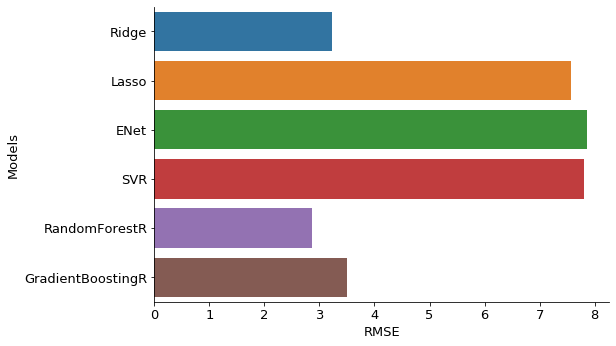

In [488]:
with plt.rc_context(rc={'font.size':13}): 
    sns.catplot(x='RMSE', y='Models', data=res, kind='bar', height=5, aspect=1.75)

### ***Amélioration* du meilleur modèle**

In [ ]:
grid_forr = {'n_estimators': [100, 200, 400], 'max_features': ['auto'],
             'min_samples_leaf': [4,8,10,16], 'min_samples_split': [4,8,16], 
             'max_depth': [4,8,16]
            }
score = 'neg_mean_squared_error'

grid_forrest = GridSearchCV(RandomForestRegressor(), grid_forr, cv=5, 
                            scoring=score, verbose=1, n_jobs=-1)
grid_forrest.fit(X_train, y_train)
print(grid_forrest.best_params_)

In [510]:
tsv = TimeSeriesSplit(n_splits=5)
i = 1
score = []
columns = df.columns.drop(['count', 'count_log'])

for train_index, test_index in tsv.split(df):
    print('--'*20)
    print('Cross-val on {}-th/{} iteration'.format(i, tsv.n_splits))
    print('--'*20)
    df_train, df_test = df.iloc[train_index, :], df.iloc[test_index, :]    
    print("TRAIN:", df_train.shape, "TEST:", df_test.shape)
    X_tr, y_tr = df_train[columns], df_train['count_log']
    X_val, y_val = df_test[columns], df_test['count_log']    
    
    # loop over hyperparams
    for mf in np.linspace(50, 100, 2):
        for ne in np.linspace(100, 500, 3):
            for md in np.linspace(4, 30, 3):
                for msl in np.linspace(4, 30, 3):
                    clf = RandomForestRegressor(max_features=int(mf), 
                                                n_estimators=int(ne), 
                                                max_depth=int(md), 
                                                min_samples_leaf=int(msl),
                                                n_jobs=-1,
                                                random_state=28)
                    clf.fit(X_tr, y_tr)
                    y_pr = clf.predict(X_val)
                    score.append([i, mf, ne, md, msl, r2_score(y_pr, y_val), compute_rmse(y_pr, y_val)])
    i += 1

----------------------------------------
Cross-val on 1-th/5 iteration
----------------------------------------
TRAIN: (1816, 135) TEST: (1814, 135)
----------------------------------------
Cross-val on 2-th/5 iteration
----------------------------------------
TRAIN: (3630, 135) TEST: (1814, 135)
----------------------------------------
Cross-val on 3-th/5 iteration
----------------------------------------
TRAIN: (5444, 135) TEST: (1814, 135)
----------------------------------------
Cross-val on 4-th/5 iteration
----------------------------------------
TRAIN: (7258, 135) TEST: (1814, 135)
----------------------------------------
Cross-val on 5-th/5 iteration
----------------------------------------
TRAIN: (9072, 135) TEST: (1814, 135)


In [512]:
grid = pd.DataFrame(score, columns=['cv_id', 'max_features', 'n_estimators', 'max_depth',
                             'min_sample_leaf', 'r2_score', 'rmse'])
print(grid.shape)
grid.head()

(270, 7)


,cv_id,max_features,n_estimators,max_depth,min_sample_leaf,r2_score,rmse
0,1,50.00,100.00,4.00,4.00,-0.68,5.45
1,1,50.00,100.00,4.00,17.00,-0.76,5.57
2,1,50.00,100.00,4.00,30.00,-0.80,5.58
3,1,50.00,100.00,17.00,4.00,0.09,4.60
4,1,50.00,100.00,17.00,17.00,-0.40,5.10


In [514]:
grid['rmse'].sort_values()

213   2.56
204   2.56
195   2.56
201   2.57
210   2.57
      ... 
218   5.84
216   5.85
146   5.97
155   5.97
137   5.97
Name: rmse, Length: 270, dtype: float64

In [516]:
grid.iloc[213]

cv_id               4.00
max_features      100.00
n_estimators      500.00
max_depth          30.00
min_sample_leaf     4.00
r2_score            0.91
rmse                2.56
Name: 213, dtype: float64

In [520]:
best_model = RandomForestRegressor(n_estimators=500, max_features=100, max_depth=30, 
                                   random_state=28, min_samples_leaf=4)
best_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features=100, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=28, verbose=0, warm_start=False)

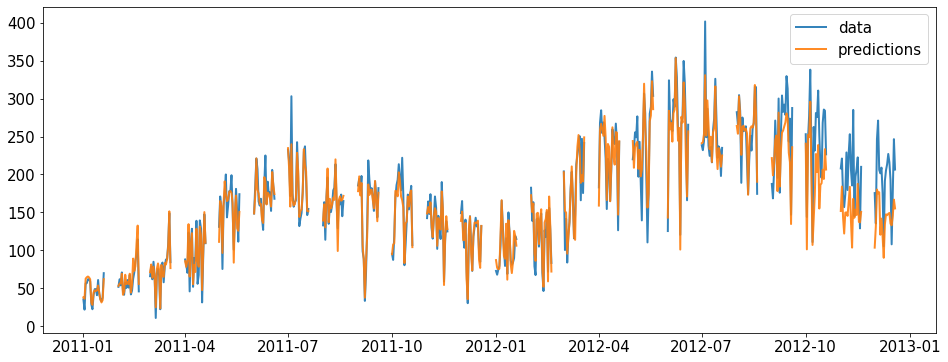

In [525]:
df['predicted'] = inv_boxcox1p(best_model.predict(X_test), 0.4)
df_day = df.groupby(pd.Grouper(freq='d'))
x, y = df_day['count'].mean().index, df_day['count'].median().values
xp, yp = df_day['predicted'].mean().index, df_day['predicted'].median().values

with plt.rc_context(rc={'font.size':15}): 
    fig, ax = plt.subplots(figsize=(16,6))
    line, = ax.plot(x, y, alpha=0.9, linewidth=2, label='data')
    linep, = ax.plot(xp, yp, alpha=0.9, linewidth=2, label='predictions')   
    #ax.fill_between(x, y1=y, y2=-y, alpha=0.1, linewidth=2, color=line.get_color())
    #ax.fill_between(xp, y1=yp, y2=-yp, alpha=0.4, linewidth=2, color=linep.get_color())
    ax.legend(loc='best')

<a id="content2"></a>
# <font color='blue'>III) Plus loin</font>

- **Expliquer simplement 1 ou 2 méthodes qui existent aujourd’hui afin d’expliquer un modèle de machine learning et donner un sens métier à ces prédictions ?**

Application du Lasso très facile niveau représentation graphe --> permet d'avoir très facilement une idée des features/colonnes des données qui ont un *poids* dans la prédiction final du prix.
--> sens métier: ces features *non importantes* montrent par exemple que la saisonalité n'influe pas sur le nombre de locations -->. faire des tarifs d'été ne sont par exemple pas essentiels, ou encore faire des tickets week-end à transformer en tickets jeudi-dimanche ou jeudi-samedi 48h plutot plus avantageux : jeudi 18h --> dimanche 12h. 

In [23]:
# Really basic basic fit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_squared_log_error

X = df.drop(columns=['count', 'casual', 'registered'], axis=1)
y = df['count']
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
df['predicted'] = model.predict(X)

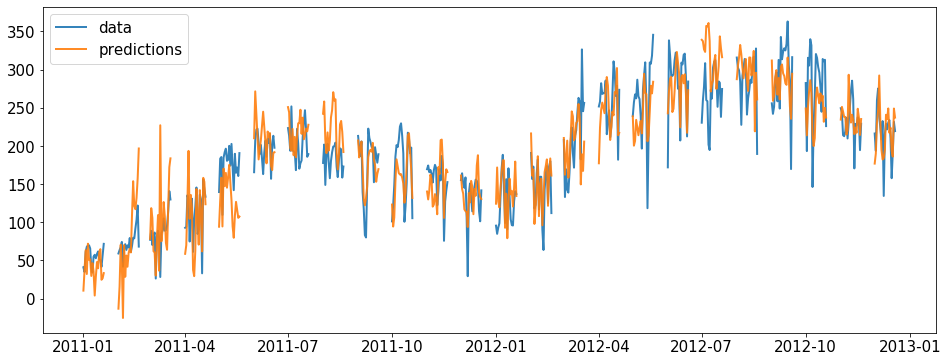

In [40]:
df['predicted'] = model.predict(X)
df_day = df.groupby(pd.Grouper(freq='d'))
x, y = df_day['count'].mean().index, df_day['count'].mean().values
xp, yp = df_day['predicted'].mean().index, df_day['predicted'].mean().values

with plt.rc_context(rc={'font.size':15}): 
    fig, ax = plt.subplots(figsize=(16,6))
    line, = ax.plot(x, y, alpha=0.9, linewidth=2, label='data')
    #ax.fill_between(x, y1=y, y2=-y, alpha=0.1, linewidth=2, color=line.get_color())
    linep, = ax.plot(xp, yp, alpha=0.9, linewidth=2, label='predictions')   
    #ax.fill_between(xp, y1=yp, y2=-yp, alpha=0.4, linewidth=2, color=linep.get_color())
    ax.legend(loc='best')

In [26]:
# RMSE / RMSLE

ytrue, ypred = df['count'], df['predicted']
rmse = np.sqrt(mean_squared_error(ytrue, ypred))
print(f'RMSE: {rmse:.3f}')

RMSE: 141.540


In [33]:
# Mean value as predictions
data = df.copy()
data['predicted'] = data['count'].mean()

ypred = data['predicted']
rmse = np.sqrt(mean_squared_error(ytrue, ypred))
print(f'RMSE: {rmse:.3f}')

RMSE: 181.136


In [34]:
# Zéro value as predictions
data = df.copy()
data['predicted'] = 0

ypred = data['predicted']
rmse = np.sqrt(mean_squared_error(ytrue, ypred))
print(f'RMSE: {rmse:.3f}')

RMSE: 263.649


In [19]:
from sklearn.utils import resample
params = pd.Series(model.coef_, index=X.columns)
err = np.std([model.fit(*resample(X, y)).coef_ 
              for i in range(100)], 0)
pd.DataFrame({'params': params.round(0), 'error': err.round(0)})

,params,error
season,-7.0,5.0
holiday,-166567.0,5141.0
workingday,-166562.0,5140.0
weather,-5.0,2.0
temp,2.0,1.0
atemp,5.0,1.0
humidity,-2.0,0.0
windspeed,1.0,0.0
week_number,-0.0,0.0
day_month,0.0,0.0
